# UBER pick-up data 
FiveThirtyEight generously shared the data they used for a few of their articles related to the UBER usage in New York. We will see how some of the distributions that we saw in class may appear in various kinds of questions we may ask about the data.

- In order to make use of this Jupyter Notebook, you need to have pandas, numpy, scipy, matplotlib and ipywidgets packages. 
- To get the data, visit and clone https://github.com/caesar0301/awesome-public-datasets, and note the path to the repo. 

Here are the probability mass functions for the discrete distributions in the class notes at section 3.2:
- Bernoulli: $X$ with $p_X(0) = p$ and $ p_X(1) = 1-p$
- Geometric: $X$ with $p_X(k) = (1-p)^{k-1}p$
- Binomial: $X$ with $p_X(k) = {n \choose k} p^k(1-p)^{n-k}$
- Poisson: $X$ with $p_X(k) = \frac{\lambda^ke^{-\lambda}}{k!}$

We will practice how to ask the right kind of questions that will give rise to the above distributions and we will check our results. 

*Note:* You will only need to submit your answers to the questions, no code submission is required. Also, the code is not intended to be efficient, but it is intended to allow you to easily play with it, feel free to change the script as you wish. 

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy, scipy.stats
%matplotlib inline
from ipywidgets import interact

**WARNINGs**
- Point PATH_DATA to the path where you cloned the above repository. 
- In the below code, only uber-raw-data-janjune-15.csv is being used, for the answers check what dates are asked. 

In [6]:
PATH_DATA = "/Users/leventsagun/GitHub/uber-tlc-foil-response/uber-trip-data/"
all_pickups = pd.read_csv(PATH_DATA + 'uber-raw-data-janjune-15.csv')
print 'Total number of data points: ', len(all_pickups)
all_pickups[:3] 

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100


# 1. Bernoulli
For a given two time periods, we may wonder how many of the rides take place in each of them to compare the usage traffic in the given windows: What is the rate at which the rides are taking place in comparison to one another. Another way to ask this is the following, what is the chance of a randomly picked UBER ride has a pick-up date within the first time period? We can clearly model this with a Binomial variable.

In [24]:
# isolate the hour information from the full date and add as a column
all_pickups['Pickup_hour'] = all_pickups['Pickup_date'].apply(lambda(x): int(x[11:13]))
print 'possible pick-up hours:'
print sorted(all_pickups.Pickup_hour.unique())

possible pick-up hours:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [25]:
# let's focus on 2015-01-01 by isolating the day information
all_pickups['Pickup_day'] = all_pickups['Pickup_date'].apply(lambda(x): x[0:10])
small_data = all_pickups.groupby('Pickup_day').get_group('2015-01-01') 
print 'number of data points used in the example Binomial case: ', len(small_data)
small_data[:3]

number of data points used in the example Binomial case:  58045


,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Pickup_hour,Pickup_day
44141,B02598,2015-01-01 15:43:04,B02598,89,15,2015-01-01
44142,B02598,2015-01-01 17:09:38,B02598,148,17,2015-01-01
44143,B02598,2015-01-01 02:10:01,B02789,164,2,2015-01-01


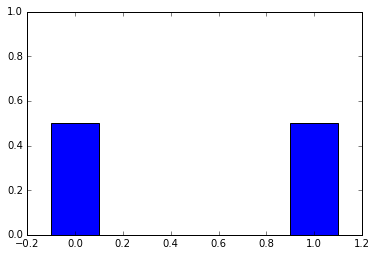

In [60]:
def get_p_before_threshold(threshold, data):
    return len(data[data['Pickup_hour'] < threshold])/float(len(data))

def plot_binomial(threshold):
    p = get_p_before_threshold(threshold, small_data)
    plt.bar([-0.1, 0.9], [p, 1 - p], width=0.2)
    plt.ylim(0,1)
    plt.show()
    
# play with the slider to change the threshold hour
interact(plot_binomial, threshold=(0, 24, 1));

# 2. Geometric
In the time-ordered list of all rides in all locations for a given time window, look at a given a location. What is the index of finding the next UBER trip with that location? If we think that it is reasonable to assume that the time of a ride taken is independent of its location (at least roughly), then we can think of this problem as follows: At every index, we consider it a success to have a ride from the given location, and failure otherwise. This can be modeled by a geometric distribution.

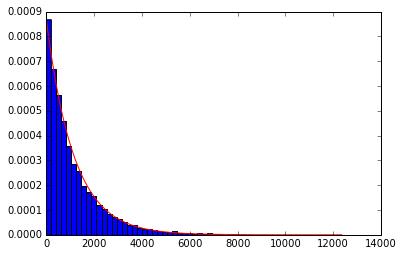

In [117]:
def get_times(loc_ID):
    finding_times = []
    t_current = all_pickups[all_pickups['locationID'] == loc_ID].index[0]
    for t_next in all_pickups[all_pickups['locationID'] == loc_ID].index[1:]:
        finding_times.append(t_next - t_current)
        t_current = t_next
    return finding_times

def plot_geometric(loc_ID):
    times = get_times(loc_ID)
    plt.hist(times, bins=50, normed=True)
    # exponential fit
    p = len(all_pickups[all_pickups['locationID'] == loc_ID])/float(len(all_pickups))
    x = range(len(times))
    y = scipy.stats.geom.pmf(x, p)
    plt.plot(y, 'r')
    plt.show()
    
interact(plot_geometric, loc_ID=(1, 265, 1));

# 3. Binomial
Each location zone is associated with a Borough. For every randomly picked 20 rides, how many of them will be picked up in Manhattan? We can model this problem with a Binomial variable with its empirical parameter. We can also repeatedly sample 20 rides, and observe how many turn out to be from Manhattan.

In [143]:
zones = pd.read_csv(PATH_DATA + 'taxi-zone-lookup.csv').rename(columns={"LocationID": "locationID"})
all_pickups_zones = all_pickups.merge(zones, how='inner', on='locationID')
data = all_pickups_zones.groupby('Pickup_day').get_group('2015-01-01') # again focus on 2015-01-01
data[:3]

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Pickup_hour,Pickup_day,Borough,Zone
605,B02598,2015-01-01 13:01:14,B02765,141,13,2015-01-01,Manhattan,Lenox Hill West
610,B02598,2015-01-01 13:54:04,B02598,141,13,2015-01-01,Manhattan,Lenox Hill West
611,B02598,2015-01-01 00:24:17,B02598,141,0,2015-01-01,Manhattan,Lenox Hill West


empirical average value:  13.1429063658


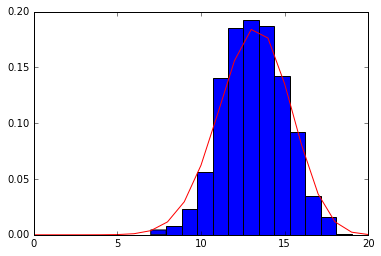

In [144]:
def plot_binomial(n):
    p_empirical = len(data.groupby('Borough').get_group('Manhattan'))/float(len(data))
    print 'empirical average value: ', p_empirical*n

    k_observed = []
    for i in range(1000):
        idx = np.random.randint(0, len(data.index), n)
        k_observed.append(len(data.iloc[idx].groupby('Borough').get_group('Manhattan')))

    x = scipy.linspace(0, n, n+1)
    binomial = scipy.stats.binom.pmf(x, n, p_empirical)
    plt.hist(k_observed, max(k_observed) - min(k_observed) + 1, normed=True)
    plt.plot(x, binomial, 'r')
    plt.show()

interact(plot_binomial, n=(1,40,1));

# 4. Poisson
Each location zone is associated with a Zone. If we randomly pick 200 rides, how many of them will be picked up in Greenpoint? We can model this problem with a Poisson variable with its empirical parameter, and we repeatedly sample and observe how many turn out to be from Greenpoint.

empirical value of the Poisson parameter:  3.22163838401


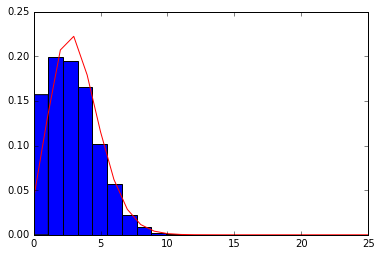

<function __main__.plot_poisson>

In [145]:
def plot_poisson(n):
    p_empirical = len(data.groupby('Zone').get_group('Greenpoint'))/float(len(data))
    print 'empirical value of the Poisson parameter: ', p_empirical*n
    k_experimental = []
    for i in range(1500):
        idx = np.random.randint(0, len(data.index), n)
        data_temp = data.iloc[idx]
        k_experimental.append(len(data_temp[data_temp['Zone'] == 'Greenpoint']))
    plt.hist(k_experimental, normed=True)
    x = scipy.linspace(0, n, n+1)
    y = scipy.stats.poisson.pmf(x, n*p_empirical)
    plt.xlim(0, 25)
    plt.plot(x, y, 'r')
    plt.show()

interact(plot_poisson, n=(1,400,1))